In [7]:
#!pip install netCDF4

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import glob
from netCDF4 import Dataset
import json
%matplotlib inline

In [2]:
# era_AREA = area_grid_cell(lat, 0.375, 0.375)

In [3]:
nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'
#nc_path  = '//home/hanna/Desktop/examples_master_thesis/'
nc_file  = glob.glob(nc_path + '*.nc')[0]
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan
#d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
#d_theta = lat_array[1:, :] - lat_array[:-1, :]

# Padding the axis -- we removed by taking the difference
#pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values
#d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
#d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

In [4]:
rootgrp

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    creator_name: EUMETSAT
    creator_url: http://archive.eumetsat.int
    creator_email: archive@eumetsat.int
    institution: EUMETSAT
    license: CopyRight EUMETSAT 2008
    Conventions: CF-1.0
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    title: EUMETSAT-ARCHIVE-CLOUD-MASK-NetCDF
    summary: NA
    keywords: EUMETSAT, ARCHIVE, NetCDF, CLOUD MASK
    history: EUMETSAT CopyRight 2008
    comment: DRAFT VERSION
    wmo_filename: W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190613053000.nc
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: 0.0
    GRIB_param_Nx: 3712
    GRIB_param_Ny: 3712
    GRIB_orgReferenceTime: 20190613053000
    time_coverage_start: 20190613053000
    time_coverage_end: 20190613053000
    source: /data/products/1338648/MSG4-SEVI-MSGCLMK-0100-0100-20190613053000.000000000Z-20190613054348-1338648.nc.tmp
    dimensions(

In [78]:
def area_grid_cell(c_lat, d_lat, d_lon):
        """
        c_lat : float
            Centre point longitude, latitude in degrees

        d_lat, d_lon : float
            delta lat lon in degrees

        Returns : area in km^2

        cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
        """
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return area


In [79]:
def compute_dDegrees(lat, lon):
    """
    lat, lon shape is (3712, 3712).
    """
    
    assert lat.shape == lon.shape == (3712, 3712), 'Wrong shape of lat and lon expected (3712, 3712), got lat.shape {} and lon.shape {}'.format(lat.shape, lon.shape)
    
    d_phi    = np.nan*np.zeros(np.shape(lat))
    d_theta  = np.nan*np.zeros(np.shape(lat))
    cell_areas = np.nan*np.zeros(np.shape(lat))
    
    for i in range(1, len(lat)-1):
        for j in range(1, len(lat)-1):
            left_half_dist     = (lon[i, j]   - lon[i, j+1])/2
            right_half_dist    = (lon[i, j-1] - lon[i, j])/2                
            #print("left_half_dist {}, right _half_dist {}".format(left_half_dist, right_half_dist))
            dlon               = (np.abs(left_half_dist) + np.abs(right_half_dist))/2
            d_phi[i][j]        = dlon

            upper_half_dist    = (lat[i+1, j] - lat[i, j])/2
            lower_half_dist    = (lat[i, j] - lat[i-1, j])/2
            #print("upper_half_dist {}, lower_half_dist {}".format(upper_half_dist, lower_half_dist))
            dlat               = (np.abs(upper_half_dist) + np.abs(lower_half_dist))/2
            d_theta[i][j]      = dlat
                
            cell_areas[i][j] = area_grid_cell(lat[i, j], dlat, dlon)       
            
    return d_phi, d_theta, cell_areas

In [80]:
d_phi, d_theta, cell_areas = compute_dDegrees(lat_array, lon_array)

In [81]:
def add(a, b):
    return np.abs(a) + np.abs(b)

def subtract(a, b):
    return np.abs(np.abs(a) - np.abs(b))

In [82]:
areas = []
lats = np.arange(30, 56, 5) 
lons = np.arange(-15, 30, 5)
c_lat = lat_array.reshape(-1)
c_lon = lon_array.reshape(-1)
d_theta = d_theta.reshape(-1)
d_phi = d_phi.reshape(-1)
cloud_mask_array = cloud_mask.reshape(-1) 

assert c_lon.shape == c_lat.shape == d_theta.shape == d_phi.shape == cloud_mask_array.shape, " c_lon.shape {},  c_lat.shape {},  d_theta.shape {}, d_phi.shape {} cloud_mask_array.shape {}".format(c_lon.shape,  c_lat.shape,  d_theta.shape, d_phi.shape, cloud_mask_array.shape) 

data = {}
for lat in lats:
    data[str(lat)] = {}
    for lon in lons:
        data[str(lat)][str(lon)] = {}
        era_AREA = area_grid_cell(lat, 0.375, 0.375)
        #print("lat = {}, lon ={} era_AREA {}".format(era_AREA, lat, lon))
        
        era_up    = lat + 0.375
        era_down  = lat - 0.375
        era_left  = lon - 0.375
        era_right = lon + 0.375

        # to ensure correct sign
        cmk_left  = c_lon - np.abs(d_phi)   #- era_right
        cmk_right = c_lon + np.abs(d_phi)   #- era_left

        # TODO : Sjekk d theta og lignende.
        cmk_up    = c_lat + np.abs(d_theta) #- era_down
        cmk_down  = c_lat - np.abs(d_theta) #- era_up

        data[str(lat)][str(lon)]['centre'] = {}
        data[str(lat)][str(lon)]['down'] = {}
        data[str(lat)][str(lon)]['up'] = {}
        data[str(lat)][str(lon)]['right'] = {}
        data[str(lat)][str(lon)]['left'] = {}
        data[str(lat)][str(lon)]['corner'] = {}

        idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
        idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
        idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up),       np.argwhere(cmk_down < era_up) )
        idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down),     np.argwhere(cmk_down < era_down) )

        data[str(lat)][str(lon)]['down']['index']  = idx_down_boundary.tolist()
        data[str(lat)][str(lon)]['up']['index']    = idx_up_boundary.tolist()
        data[str(lat)][str(lon)]['left']['index']  = idx_left_boundary.tolist()
        data[str(lat)][str(lon)]['right']['index'] = idx_right_boundary.tolist()

        idx_lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
        idx_lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
        idx_upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
        idx_upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

        corner_idx         = np.concatenate([idx_lower_right_corner, idx_lower_left_corner,
                                             idx_upper_left_corner, idx_upper_right_corner]) # corner idx
        data[str(lat)][str(lon)]['corner']['index'] = corner_idx.tolist()
        #assert len(corner_idx) == 4, "Not correct number of corners, nbr = {}.".format(len(corner_idx))

        if len(corner_idx) != 4:
            print("left bound {}".format(cmk_left[corner_idx]))
            print("right bound {}".format(cmk_right[corner_idx]))
            print("up bound {}".format(cmk_up[corner_idx]))
            print("down bound {}".format(cmk_down[corner_idx]))

        # TODO add new centre corners. And calculate  
        llc_dlat = subtract(cmk_up[idx_lower_left_corner], era_down)/2
        llc_dlon = subtract(era_left, cmk_right[idx_lower_left_corner])/2
        llc_lat  = era_down + llc_dlat

        llc_area = area_grid_cell(llc_lat, llc_dlat, llc_dlon)
        #print("area lower left area {}".format(f/era_AREA))

        lrc_dlat = subtract(cmk_up[idx_lower_right_corner], era_down)/2
        lrc_dlon = subtract(cmk_left[idx_lower_right_corner], era_right)/2

        lrc_lat  = era_down + lrc_dlat
        lrc_area = area_grid_cell(lrc_lat, lrc_dlat, lrc_dlon)
        #print("area lower right area {}".format(h/era_AREA))

        ulc_dlat = subtract(era_up, cmk_down[idx_upper_left_corner])/2
        ulc_dlon = subtract(era_left, cmk_right[idx_upper_left_corner])/2
        ulc_lat = era_up - ulc_dlat
        ulc_area = area_grid_cell(ulc_lat, ulc_dlat, ulc_dlon)
        #print("area upper left area {}".format(i/era_AREA))

        urc_dlat = subtract(era_up, cmk_down[idx_upper_right_corner])/2
        urc_dlon = subtract(cmk_left[idx_upper_right_corner], era_right)/2
        urc_lat  = era_up - ulc_dlat
        urc_area = area_grid_cell(urc_lat, urc_dlat, urc_dlon)
        #print("area upper right area {}".format(j/era_AREA))
        #print("SUM corners {}".format((i+j+h+f)/era_AREA))

        corner_areas = np.array([lrc_area, llc_area, ulc_area, urc_area])
        data[str(lat)][str(lon)]['corner']['area'] = corner_areas.tolist()

        if len(corner_idx) == 0:
            raise ValueError('No corners found, something is wrong ... ')

        #assert len(corner_idx) == 4, "Expected four corners, got {}".format(len(corner_idx))

        #max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
        #max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

        # removes corners
        for idx in corner_idx:
            idx_down_boundary = idx_down_boundary[idx_down_boundary != idx]
            idx_up_boundary = idx_up_boundary[idx_up_boundary != idx]
            idx_left_boundary = idx_left_boundary[idx_left_boundary != idx]
            idx_right_boundary = idx_right_boundary[idx_right_boundary != idx]

        #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
        #idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

        #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
        #idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

        #idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
        #idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

        #idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
        #idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]

        # subsection left boundary OLD
        low_bound = np.argwhere(cmk_down[idx_left_boundary] < era_up)
        up_bound  = np.argwhere(cmk_up[idx_left_boundary]   > era_down)
        sub_section_left = np.intersect1d(low_bound, up_bound)

        data[str(lat)][str(lon)]['left']['index_subset'] = sub_section_left.tolist()

        # subsection right boundary
        low_bound = np.argwhere( cmk_down[idx_right_boundary] < era_up )
        up_bound  = np.argwhere( cmk_up[idx_right_boundary]   > era_down)
        sub_section_right = np.intersect1d(low_bound, up_bound)
        data[str(lat)][str(lon)]['right']['index_right'] = sub_section_right.tolist()

        # Subsection Down Boundary
        #one = np.argwhere(cmk_left[idx_down_boundary]  > era_left)
        #two = np.argwhere(cmk_right[idx_down_boundary] < era_right)

        one = np.argwhere(cmk_right[idx_down_boundary]  > era_left)
        two = np.argwhere(cmk_left[idx_down_boundary]   < era_right)
        sub_section_down = np.intersect1d(one, two)
        data[str(lat)][str(lon)]['down']['index_subset'] = sub_section_down.tolist()

        # subsection up boundary
        one = np.argwhere( cmk_right[idx_up_boundary]  > era_left)
        two = np.argwhere( cmk_left[idx_up_boundary] < era_right)
        sub_section_up = np.intersect1d(one, two)
        data[str(lat)][str(lon)]['up']['index_subset'] = sub_section_up.tolist()
        #plt.scatter(cmk_left[corner_idx], cmk_up[corner_idx],        marker = 'v')
        #plt.scatter(cmk_left[idx_left_boundary][sub_section_left],   cmk_up[idx_left_boundary][sub_section_left])
        #plt.scatter(cmk_left[idx_right_boundary][sub_section_right], cmk_up[idx_right_boundary][sub_section_right])
        #plt.scatter(cmk_left[idx_up_boundary][sub_section_up],       cmk_up[idx_up_boundary][sub_section_up])
        #plt.scatter(cmk_left[idx_down_boundary][sub_section_down],   cmk_up[idx_down_boundary][sub_section_down])
        #plt.show()

        # test that these are empty
        t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
        t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
        assert len(t1) == len(t2) == 0, "intercept up down  {}, intersect left right {}.".format(t1, t2)

        # Calculate Boundaries

        # AREA left boundary
        dlon_lf = subtract(cmk_right[idx_left_boundary][sub_section_left], era_left)/2 
        dlat_lf = d_theta[idx_left_boundary][sub_section_left]
        lat_lf  = c_lat[idx_left_boundary][sub_section_left]
        #lon_lf  = c_lon[idx_left_boundary][sub_section_left]
        left_areas = area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf))
        data[str(lat)][str(lon)]['left']['area'] = left_areas.tolist()

        a = np.sum(left_areas)

        fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf,
                                                                                              dlat_lf,
                                                                                              dlon_lf)/era_AREA).sum()
        # AREA right boundary
        dlon_rb = subtract(era_right, cmk_left[idx_right_boundary][sub_section_right])/2
        dlat_rb = d_theta[idx_right_boundary][sub_section_right]
        lat_rb  = c_lat[idx_right_boundary][sub_section_right]
        #lon_rb = c_lon[idx_right_boundary][sub_section_right]
        right_area = area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)) 
        data[str(lat)][str(lon)]['right']['area'] = right_area.tolist()
        b = np.sum(right_area)

        fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb,
                                                                                                 dlat_rb,
                                                                                                 dlon_rb)/era_AREA).sum()

        # AREA down boundary
        dlat_down = subtract(era_down, cmk_up[idx_down_boundary][sub_section_down])/2
        lat_down = era_down + dlat_down
        dlon_down = d_phi[idx_down_boundary][sub_section_down]
        #lon_down =  c_lon[idx_down_boundary][sub_section_down]
        down_area = area_grid_cell(lat_down, dlat_down, dlon_down)
        c = np.sum(down_area)
        data[str(lat)][str(lon)]['down']['area'] = down_area.tolist()
        fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down,
                                                                                              dlat_down,
                                                                                              dlon_down)/era_AREA).sum()
        # AREA up
        dlat_up = subtract(era_up, cmk_down[idx_up_boundary][sub_section_up])/2
        lat_up = era_up - dlat_up
        #lon_up = c_lon[idx_up_boundary][sub_section_up]
        dlon_up = d_phi[idx_up_boundary][sub_section_up]
        up_area = area_grid_cell(lat_up, dlat_up, np.abs(dlon_up))
        data[str(lat)][str(lon)]['up']['area'] = up_area.tolist()
        
        d = np.sum(up_area)

        fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up,
                                                                                         dlat_up,
                                                                                         dlon_up)/era_AREA).sum()
        # Index centres. Can safly assume centre cells are correct.
        idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left),
                                        np.argwhere(cmk_right < era_right))
        
        idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up),
                                        np.argwhere(cmk_down >  era_down))

        idx_centre_cells = np.intersect1d( idx_centre_one, idx_centre_two )
        data[str(lat)][str(lon)]['centre']['index'] = idx_centre_cells.tolist()

        lat_centre_cells = c_lat[idx_centre_cells]
        dlat_centre      = d_theta[idx_centre_cells]
        dlon_centre      = d_phi[idx_centre_cells]
        centre_area      = area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre)

        data[str(lat)][str(lon)]['centre']['area'] = centre_area.tolist()
        
        #plt.scatter(cmk_left[idx_centre_cells], cmk_up[idx_centre_cells])
        #plt.scatter([lon+.375, lon-.375, lon+.375, lon-.375,], [lat+.375, lat+.375, lat-.375,lat-.375])
        #plt.show()

        fraction_centre  = (cloud_mask_array[idx_centre_cells]*centre_area/era_AREA).sum()
        
        #print("era_AREA {}".format(era_AREA))
        #print("Sum up {}".format(area_grid_cell(lat_up, dlat_up, dlon_up).sum()/era_AREA))
        #print("Sum down {}".format(area_grid_cell(lat_down, dlat_down, dlon_down).sum()/era_AREA))
        #print("Sum centre {}".format(area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() /era_AREA))
        #print("Sum left {}".format(area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum()/era_AREA))
        #print("Sum right {}".format(area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum()/era_AREA))

        Test_weight = (area_grid_cell(lat_up, dlat_up, dlon_up).sum() +
                       area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre).sum() +
                       area_grid_cell(lat_down, dlat_down, dlon_down).sum() +
                       area_grid_cell(lat_rb, dlat_rb, dlon_rb).sum() +
                       area_grid_cell(lat_lf, dlat_lf, dlon_lf).sum() )/era_AREA + (corner_areas.sum())/era_AREA
        
        areas.append(Test_weight)
        #print("area fraction {}".format(Test_weight))


/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in greater
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in less
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value enc

In [83]:
areas

[1.0048154075085134,
 1.0021257998845294,
 1.0005303744765612,
 1.0000019161554272,
 1.0005303813436062,
 1.0021258482116517,
 1.0048152951186888,
 1.0086282812399268,
 1.0135785641642507,
 1.006734837664537,
 1.002911787055998,
 1.0007261708702544,
 1.0000022138759697,
 1.0007262432982993,
 1.0029118485658537,
 1.0067346852027828,
 1.0119866168357166,
 1.0189174246403736,
 1.0089654065206668,
 1.0039316611473295,
 1.0009682675500082,
 1.0000030435383431,
 1.0009682941520912,
 1.0039318691630221,
 1.0089651761155387,
 1.0161177734425162,
 1.0254728880984112,
 1.0118791690181517,
 1.005135289505117,
 1.0012770435256988,
 1.000003300068227,
 1.0012773890027544,
 1.005135660040027,
 1.0118788399460692,
 1.021261601296291,
 1.0336025854123962,
 1.0154217318744438,
 1.006746173858547,
 1.0016883953610987,
 1.000005741128948,
 1.001688793798102,
 1.006746730837722,
 1.0154208710194712,
 1.0273677202473341,
 1.0439077076355152,
 1.0202699589872595,
 1.008950369239287,
 1.0022362082333443,
 1.

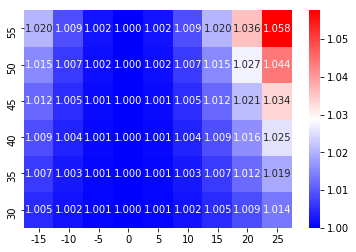

In [90]:
#fig, ax = plt.subplots(111)
#fig.set_size_inches(11,8)

ax = sns.heatmap(np.array(areas).reshape(len(lats), len(lons)), annot = True, fmt='.3f', cmap = 'bwr', vmin = 1.000)

ax.invert_yaxis()
ax.set_xticklabels(lons);
ax.set_yticklabels(lats);

In [38]:
Test_weight

1.0048204157112952

In [39]:
corner_areas

array([[0.86575007],
       [0.5810131 ],
       [1.18697162],
       [0.27826687]])

In [36]:
#data

In [27]:
with open(nc_path + 'index_area.json', 'w') as f:
    json.dump(data, f)

In [29]:
from json import load
with open(nc_path + 'index_area.json', 'r') as f:
    data = load(f)

In [34]:
#data['30']['-15']['centre'].keys()

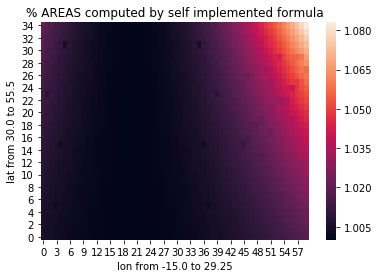

In [36]:
ax = sns.heatmap((np.array(areas)).reshape(len(lats), len(lons)))
ax.invert_yaxis()
ax.set_xlabel("lon from {} to {}".format(min(lons), max(lons)))
ax.set_ylabel("lat from {} to {}".format(min(lats), max(lats)))
#ax.yticklabels(visible = False);
#ax.set_xticklabels(lons);
ax.set_title("% AREAS computed by self implemented formula")
#plt.savefig('test_areas.png')